In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,IFrame,HTML,Image
import itertools
from z3 import *
from math import gcd
from scipy.ndimage import label,sum_labels

### Puzzle as published 
https://www.janestreet.com/puzzles/hooks-10-index/

### Hooks 10

Show Solution
The grid above can be partitioned into 9 L-shaped “hooks”. The largest is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15 squares), and so on. The smallest hook is just a single square. Find where the hooks are located, and place nine 9’s in one of the hooks, eight 8’s in another, seven 7’s in another, and so on.
The filled squares must form a connected region. (Squares are “connected” if they are orthogonally adjacent.) Furthermore, every 2-by-2 region must contain at least one unfilled square.
The clues in the grid are placed in cells that are
not
filled in the completed grid. A number in the grid represents the
sum
of all values in orthogonally adjacent cells in the completed grid.

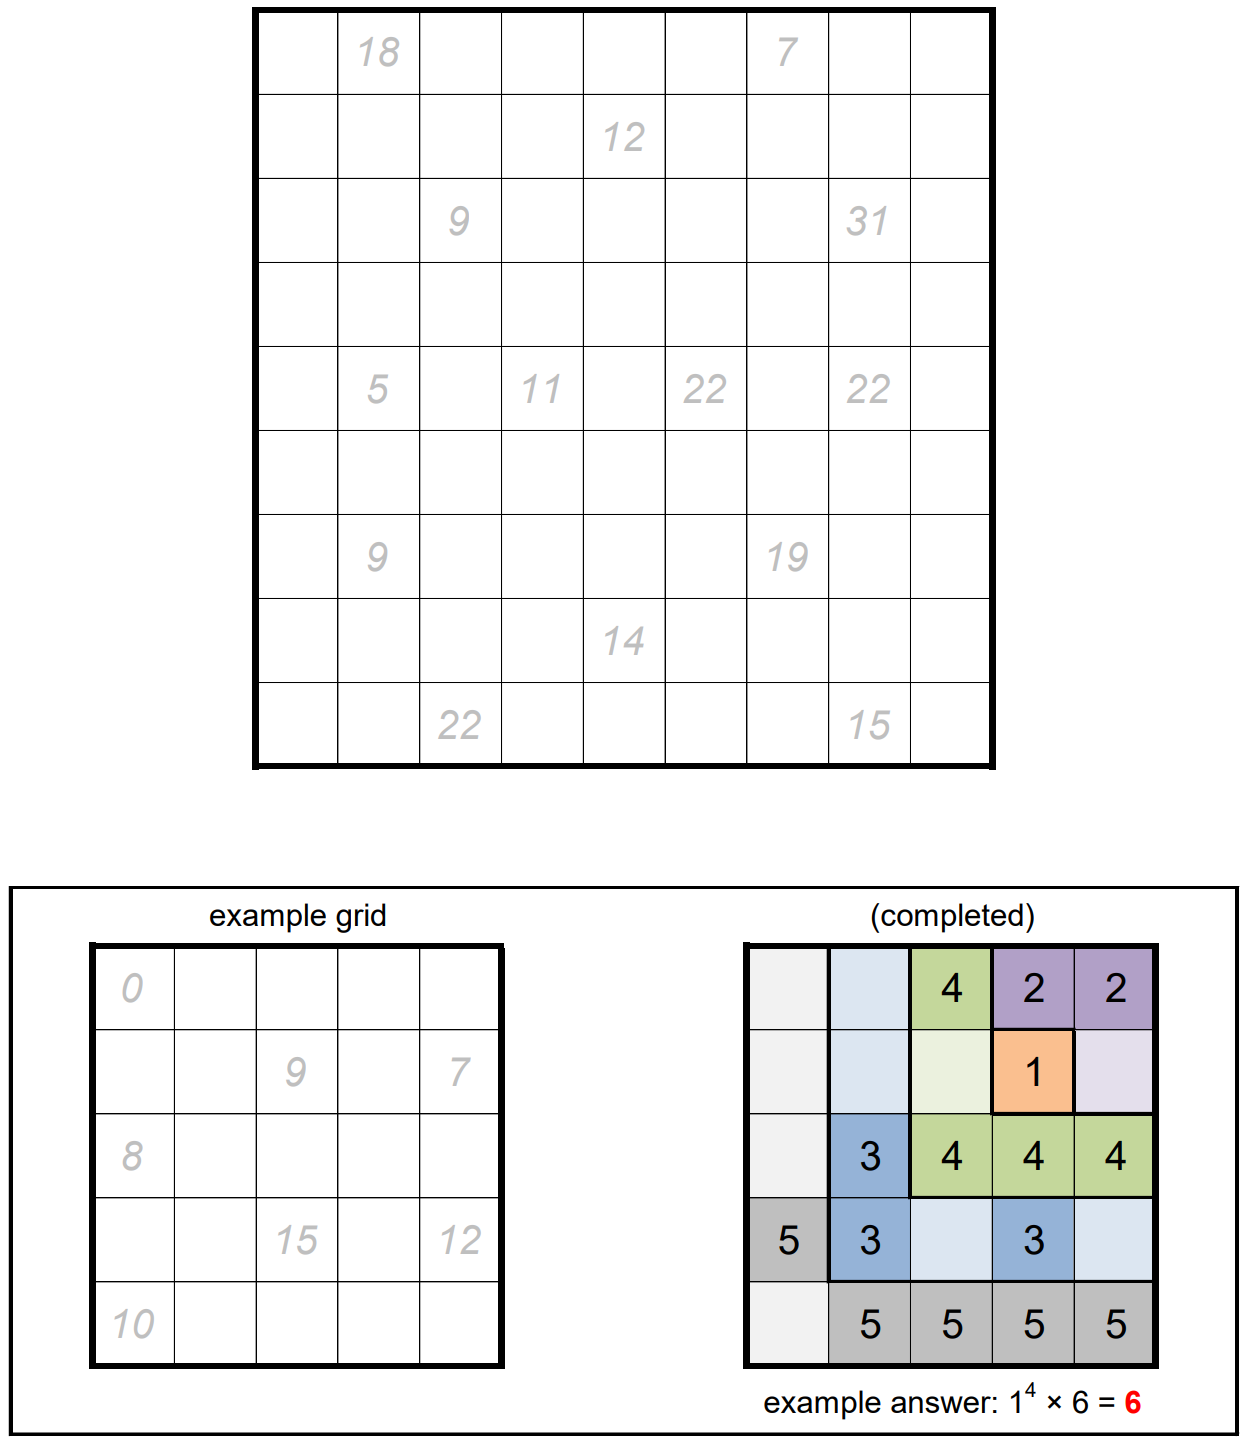

In [2]:
url='https://www.janestreet.com/puzzles/hooks-10-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[13]+"\n\n"+str("\n".join(y[15:23]))))
display(Image('https://www.janestreet.com/puzzles/hooks-10.png',width=400))

In [3]:
example =np.array([[ 0, -1, -1, -1, -1],
                  [-1, -1,  9, -1,  7],
                  [ 8, -1, -1, -1, -1],
                  [-1, -1, 15, -1, 12],
                  [10, -1, -1, -1, -1]])

full=np.array([[-1, 18, -1, -1, -1, -1,  7, -1, -1],
               [-1, -1, -1, -1, 12, -1, -1, -1, -1],
               [-1, -1,  9, -1, -1, -1, -1, 31, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1,  5, -1, 11, -1, 22, -1, 22, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1,  9, -1, -1, -1, -1, 19, -1, -1],
               [-1, -1, -1, -1, 14, -1, -1, -1, -1],
               [-1, -1, 22, -1, -1, -1, -1, 15, -1]])

In [4]:
def grid_print(solved,matrix):
    N= solved.shape[0]
    fig,ax = plt.subplots(1,1,figsize=(N/2,N/2))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(matrix,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=0.25,
                     annot_kws={"fontsize":12})
    ax.tick_params(left=False, bottom=False,labelleft=True, labelright=False,labeltop=True,labelbottom=False)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def areas(grid):
    labels, num = label(np.logical_not(grid!=0))
    areas = sum_labels(np.logical_not(grid!=0), labels, index=range(1, num+1))
    print(areas)
    return np.prod(areas)

In [5]:
def solve(grid):
    start = time.time()
    N =grid.shape[0]
    #set up the solver and variables.
    s = Tactic("qffd").solver()

    # H== hooks
    H = np.array(IntVector("h",N**2),dtype=object).reshape((N,N))

    row_fix =IntVector("r",N)
    col_fix =IntVector("c",N)

    s += [And(e>0,e<=N) for (i,j),e in np.ndenumerate(H)]
    s += [And(e>=0,e<N) for e in row_fix+col_fix]

    s += Distinct(row_fix)
    s += Distinct(col_fix)

    for n in range(1,N+1):
        s+=PbEq([(e==n,1) for _,e in np.ndenumerate(H)],2*n-1)
        if n!=1:
            s+=PbEq([(If(e==int(n),Sum([H[k,l] ==int(n) for k,l in neigh(i,j,N)]),0)==1,1)                 
                            for (i,j),e in np.ndenumerate(H)],2)    

    for n in range(N):
        s += [Implies(e == int(n+1),Or(i == row_fix[n],j == col_fix[n])) for (i,j),e in np.ndenumerate(H)]

    # X== nums  
    X = np.array(IntVector("x",N**2),dtype=object).reshape((N,N))    
    hook_num = IntVector("n",N)

    s += [And(e>0,e<N+1) for e in hook_num]
    s += [And(e>0,e<N+1) for (i,j),e in np.ndenumerate(X)]
    s += Distinct(hook_num)

    for n in range(N):
        s += [Implies(e==n+1,X[i,j]==hook_num[n]) for (i,j),e in np.ndenumerate(H)]

    # Y = filled    
    Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))
    s += [Or(e==0,e==1) for (i,j),e in np.ndenumerate(Y)]

    for n in range(1,N+1):
        s+=PbEq([(And(e==n,Y[i,j]==1),1) for (i,j),e in np.ndenumerate(X)],n)

    # no 2x2
    s += [Or(Y[i,j] ==0,Y[i+1,j] ==0,Y[i,j+1] ==0,Y[i+1,j+1] ==0) for j in range(N-1) for i in range(N-1)]

    edge ={}
    Z = np.array(IntVector('z', N*N),dtype=object).reshape(N,N)

    # create edges and variable to define order in connectivity tree
    for i in range(N):
        for j in range(N):  
            for (k,l) in neigh(i,j,N):
                edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
                s+=Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)] ==1)

    # no edges into or out of unfilled cells. Only one edge per cell     
    for i in range(N):
        for j in range(N):       
            s += Implies(Y[i,j] ==0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == 0)
            s += Implies(Y[i,j] ==0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == 0)
            s += Implies(Y[i,j] > 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) <= 1)

            for (k,l) in neigh(i,j,N):
                # Make edges one way to form a tree
                s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1

        # limit the order values
        s += [And(e>= 0 ,e <=int(N*N)) for (i,j),e in np.ndenumerate(Z)]

        # order is ascending along edges
        for i in range(N):
            for j in range(N):            
                s += [Implies(And(Y[i,j]!=0,edge[(k,l,i,j)]==1),Z[i,j] > Z[k,l]) for (k,l) in neigh(i,j,N)]

        # only one cell with no feed in => root
        s += PbEq([(And(Y[i,j] != 0,Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N) ]) == 0),1) for i in range(N) for j in range(N)],1)

        # constraints from given cells
        s += [And(Y[x,y] == 0,Sum([Y[i,j]*X[i,j] for i,j in neigh(x,y,N)])== int(e)) for (x,y),e in np.ndenumerate(grid) if e != -1]

    print("setup done in {:.2f} secs".format(time.time()-start))

    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        result_x =  evalu(X)
        result_y =  evalu(Y)
        grid_print(result_y,result_x,)
        print("Took {:.4f} seconds".format(time.time()- start))
        soln = result_x*result_y
        print("solution is {:,.0f}".format(areas(soln)))
        print(np.unique(soln,return_counts=True))
        print("Connectivity: ",np.max(label(soln>0)[0])==1)
        return soln
    else:
        print("fail")     

setup done in 0.37 secs


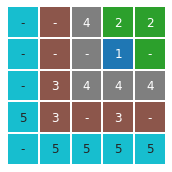

Took 0.9242 seconds
[6. 1. 1. 1. 1.]
solution is 6
(array([0, 1, 2, 3, 4, 5]), array([10,  1,  2,  3,  4,  5], dtype=int64))
Connectivity:  True


In [6]:
z = solve(example)

setup done in 1.75 secs


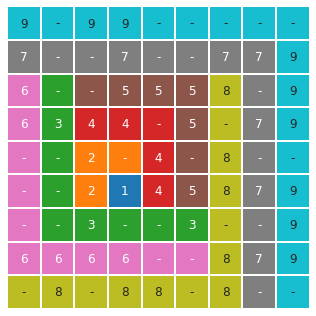

Took 27.1336 seconds
[5. 7. 1. 1. 1. 6. 1. 1. 2. 5. 2. 1. 1. 2.]
solution is 8,400
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([36,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64))
Connectivity:  True


In [7]:
z = solve(full)

### Hooks 10
The above image shows the completed grid; the product of the areas of the empty regions is
8400
.
Congrats to this month’s solvers!

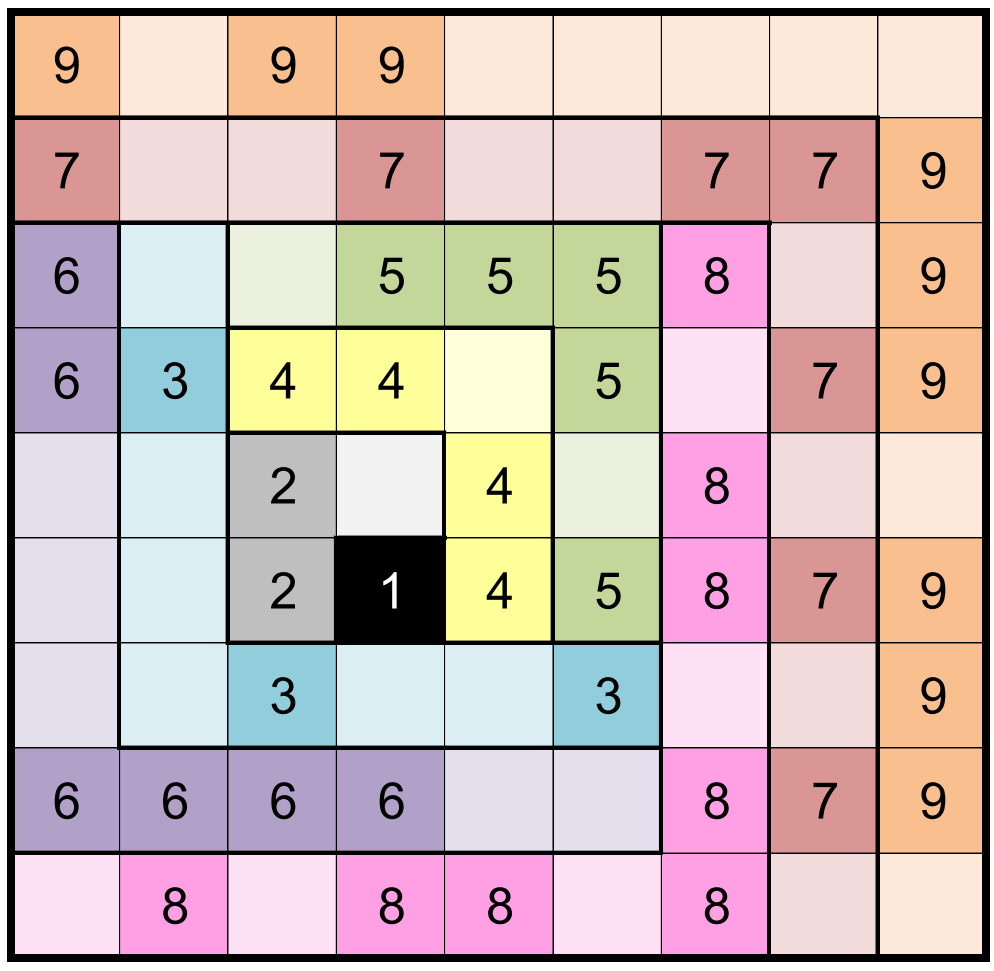

In [12]:
url='https://www.janestreet.com/puzzles/hooks-10-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text.replace(">","greater than") for text in soup.body.stripped_strings]

#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[13]+"\n"+"\n".join(y[16:20])))
display(Image('https://www.janestreet.com/puzzles/hooks-10-solution.png',width=300))

(0.0, 9.0, 9.0, 0.0)

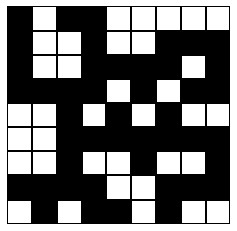

In [9]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax =sns.heatmap(z>0,cbar=False,cmap="Greys",linewidths=2,linecolor="k")
ax.axis("off")